In [3]:
import json
import pandas as pd
import numpy as np
import re
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
import datetime

class BikeValueEstimator:
    def __init__(self):
        """Inicjalizacja estymatora wartości rowerów."""
        self.model_pipeline = None
        self.df_original = None
        self.PRICE_CLASSIFICATION_THRESHOLD = 0.2  # Próg +/- 20% do klasyfikacji cen
        self.MIN_PRICE_FOR_BIKE = 500  # Minimalna cena dla roweru
        self.CURRENT_YEAR = datetime.datetime.now().year
        
    def load_data(self, file_path):
        """Wczytuje dane z pliku JSON lub CSV."""
        try:
            if file_path.endswith('.json'):
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                df = pd.DataFrame(data)
            elif file_path.endswith('.csv'):
                df = pd.read_csv(file_path, encoding='utf-8')
            else:
                raise ValueError("Niewspierany format pliku. Podaj plik JSON lub CSV.")
            
            self.df_original = df.copy()
            return df
        except Exception as e:
            print(f"Błąd wczytywania danych: {e}")
            return None
    
    def extract_year_from_text(self, text):
        """Próbuje wyekstrahować rok (np. 2020, 2021) z tekstu."""
        if not isinstance(text, str):
            return None
        match = re.search(r'\b(19[89]\d|20[0-2]\d)\b', text)
        if match:
            year = int(match.group(0))
            if year <= self.CURRENT_YEAR:
                return year
        match_date = re.search(r'\b(\d{1,2}[./-]\d{1,2}[./-](19[89]\d|20[0-2]\d))\b', text)
        if match_date:
            date_parts = re.split(r'[./-]', match_date.group(1))
            year_from_date = int(date_parts[-1])
            if year_from_date <= self.CURRENT_YEAR:
                return year_from_date
        return None
    
    def standardize_size(self, size_val, desc_val):
        """Standaryzuje rozmiar ramy do kategorii S, M, L, XL, Inny."""
        size_str = str(size_val).upper() if pd.notna(size_val) else ''
        desc_str = str(desc_val).upper() if pd.notna(desc_val) else ''
        combined = size_str + " " + desc_str

        if not combined.strip():
            return 'Nieznany'

        if 'XS' in combined or 'EXTRA SMALL' in combined: return 'XS'
        if 'S' in combined or 'SMALL' in combined or '15-16' in combined or '48' in combined or '49' in combined or '50' in combined or '51' in combined: return 'S'
        if 'M' in combined or 'MEDIUM' in combined or '17-18' in combined or '52' in combined or '53' in combined or '54' in combined: return 'M'
        if 'L' in combined or 'LARGE' in combined or '19-20' in combined or '55' in combined or '56' in combined or '57' in combined: return 'L'
        if 'XL' in combined or 'EXTRA LARGE' in combined or '21-22' in combined or '58' in combined or '59' in combined or '60' in combined: return 'XL'
        if 'XXL' in combined or '23' in combined: return 'XXL'

        if re.search(r'\b(15|16)\b', combined): return 'S'
        if re.search(r'\b(17|18)\b', combined): return 'M'
        if re.search(r'\b(19|20)\b', combined): return 'L'
        if re.search(r'\b(21|22)\b', combined): return 'XL'
        if re.search(r'\b(23|24)\b', combined): return 'XXL'

        if re.search(r'\b(48|49|50|51)\b', combined): return 'S'
        if re.search(r'\b(52|53|54)\b', combined): return 'M'
        if re.search(r'\b(55|56|57)\b', combined): return 'L'
        if re.search(r'\b(58|59|60|61)\b', combined): return 'XL'

        return 'Nieznany'
    
    def extract_numeric_feature(self, text, pattern):
        """Ekstrahuje wartość liczbową z tekstu na podstawie wzorca regex."""
        if not isinstance(text, str):
            return None
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            try:
                num_str = match.group(1).replace(',', '.')
                return float(num_str)
            except (ValueError, IndexError):
                return None
        return None
    
    def find_material(self, text):
        """Identyfikuje materiał ramy na podstawie opisu."""
        if not isinstance(text, str): return 'Nieznany'
        text_lower = text.lower()
        if 'carbon' in text_lower or 'karbon' in text_lower: return 'Carbon'
        if 'aluminium' in text_lower or 'alu' in text_lower: return 'Aluminium'
        if 'stal' in text_lower or 'steel' in text_lower or 'crmo' in text_lower or 'cro-mo' in text_lower: return 'Stal'
        if 'tytan' in text_lower or 'titanium' in text_lower: return 'Tytan'
        return 'Nieznany'
    
    def find_brake_type(self, text):
        """Identyfikuje typ hamulców na podstawie opisu."""
        if not isinstance(text, str): return 'Nieznany'
        text_lower = text.lower()
        if 'tarczowe hydrauliczne' in text_lower or 'hydrauliczne' in text_lower: return 'Tarczowe hydrauliczne'
        if 'tarczowe mechaniczne' in text_lower or 'mechaniczne' in text_lower: return 'Tarczowe mechaniczne'
        if 'tarczowe' in text_lower: return 'Tarczowe (nieokreślone)'
        if 'szczękowe' in text_lower or 'v-brake' in text_lower or 'caliper' in text_lower: return 'Szczękowe'
        if 'rolkowe' in text_lower: return 'Rolkowe'
        if 'torpedo' in text_lower or 'w piaście' in text_lower: return 'W piaście (Torpedo)'
        return 'Nieznany'
    
    def check_dataset_size(self, df):
        """Sprawdza rozmiar zbioru danych i wyświetla odpowiednie ostrzeżenia."""
        if len(df) < 5:
            print("\n!!! KRYTYCZNE OSTRZEŻENIE !!!")
            print(f"Zbyt mało danych ({len(df)} ogłoszeń) do przeprowadzenia nawet podstawowej analizy ML.")
            print("Wyniki będą oparte wyłącznie na tych niewielu punktach i będą całkowicie niewiarygodne.")
            return False
        elif len(df) < 20:
            print("\n!!! OSTRZEŻENIE !!!")
            print(f"Bardzo mała ilość danych ({len(df)} ogłoszeń). Model ML trenowany na tak małym zbiorze")
            print("będzie miał bardzo niską wiarygodność i zdolność generalizacji.")
            print("Wyniki należy traktować jako wysoce orientacyjne i specyficzne dla tych konkretnych ofert.")
            return True
        return True
    
    def preprocess_data(self, df):
        """Czyści dane i wykonuje inżynierię cech."""
        if df is None or df.empty:
            print("Brak danych do przetworzenia.")
            return None
            
        if 'price' not in df.columns:
            print("Brak kolumny 'price' w danych.")
            return None
            
        # Konwersja 'price' na numeryczny
        df['price'] = pd.to_numeric(df['price'], errors='coerce')
        
        # Usuń wiersze bez ceny
        df.dropna(subset=['price'], inplace=True)
        
        # Filtruj ogłoszenia z niską ceną
        initial_count = len(df)
        df = df[df['price'] >= self.MIN_PRICE_FOR_BIKE].copy()
        print(f"Odfiltrowano {initial_count - len(df)} ogłoszeń z ceną < {self.MIN_PRICE_FOR_BIKE} PLN.")
        print(f"Pozostało {len(df)} ogłoszeń do analizy.")
        
        # Sprawdź rozmiar zbioru danych
        if not self.check_dataset_size(df):
            return df
        
        # Upewnij się, że wszystkie potrzebne kolumny istnieją
        required_cols = ['brand', 'size', 'year', 'description', 'condition', 'frame_material', 'brake_type', 'parameters', 'title']
        for col in required_cols:
            if col not in df.columns:
                df[col] = None
        
        # Marka
        df['brand_cleaned'] = df.apply(lambda row: row['brand'] if pd.notna(row['brand']) and row['brand'] != 'Inna'
                                else (row['parameters'].get('Marka') if isinstance(row['parameters'], dict) and row['parameters'].get('Marka') != 'Inna' else 'Nieznana'), axis=1)
        df['brand_cleaned'] = df['brand_cleaned'].astype(str).str.upper().fillna('Nieznana')
        
        # Rok
        df['year_cleaned'] = pd.to_numeric(df['year'], errors='coerce')
        df['year_extracted_desc'] = df['description'].apply(self.extract_year_from_text)
        df['year_cleaned'] = df['year_cleaned'].fillna(df['year_extracted_desc'])
        df['bike_age'] = df['year_cleaned'].apply(lambda y: self.CURRENT_YEAR - y if pd.notna(y) and y <= self.CURRENT_YEAR else np.nan)
        
        # Rozmiar
        df['size_standardized'] = df.apply(lambda row: self.standardize_size(row['size'], row.get('description', '')), axis=1)
        
        # Stan
        df['condition_cleaned'] = df.apply(lambda row: row['condition'] if pd.notna(row['condition'])
                                       else (row['parameters'].get('Stan') if isinstance(row['parameters'], dict) else 'Nieznany'), axis=1)
        df['condition_cleaned'] = df['condition_cleaned'].fillna('Nieznany')
        
        # Materiał ramy
        df['frame_material_cleaned'] = df.apply(lambda row: row['frame_material'] if pd.notna(row['frame_material'])
                                            else (row['parameters'].get('Materiał ramy') if isinstance(row['parameters'], dict) else None), axis=1)
        df['frame_material_desc'] = df['description'].apply(self.find_material)
        df['frame_material_cleaned'] = df['frame_material_cleaned'].fillna(df['frame_material_desc'])
        df['frame_material_cleaned'] = df['frame_material_cleaned'].fillna('Nieznany')
        
        # Hamulce
        df['brake_type_cleaned'] = df.apply(lambda row: row['brake_type'] if pd.notna(row['brake_type'])
                                            else (row['parameters'].get('Typ hamulca') if isinstance(row['parameters'], dict) else None), axis=1)
        df['brake_type_desc'] = df['description'].apply(self.find_brake_type)
        df['brake_type_cleaned'] = df['brake_type_cleaned'].fillna(df['brake_type_desc'])
        df['brake_type_cleaned'] = df['brake_type_cleaned'].fillna('Nieznany')
        
        # Tekst do analizy
        df['text_features'] = df['title'].fillna('') + " " + df['description'].fillna('')
        
        return df
    
    def build_model(self, df):
        """Buduje model ML do predykcji cen rowerów."""
        # Wybierz cechy i cel
        numeric_features = ['bike_age']
        if 'bike_age' not in df.columns or df['bike_age'].isnull().all():
            numeric_features = []
            
        categorical_features = ['brand_cleaned', 'size_standardized', 'condition_cleaned', 'frame_material_cleaned', 'brake_type_cleaned']
        categorical_features = [col for col in categorical_features if col in df.columns]
        
        text_feature = 'text_features'
        if text_feature not in df.columns:
            text_feature = None
            
        # Sprawdź, czy mamy jakiekolwiek cechy
        if not numeric_features and not categorical_features and not text_feature:
            print("Brak cech do trenowania modelu.")
            return None
            
        # Przygotuj transformery
        transformers_list = []
        
        if numeric_features:
            numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ])
            transformers_list.append(('num', numeric_transformer, numeric_features))
            
        if categorical_features:
            categorical_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value='Nieznany')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ])
            transformers_list.append(('cat', categorical_transformer, categorical_features))
            
        if text_feature:
            text_transformer = Pipeline(steps=[
                ('tfidf', TfidfVectorizer(stop_words=['i', 'w', 'na', 'z', 'do', 'o', 'po', 'za', 'jest', 'oraz'], max_features=100, ngram_range=(1,2)))
            ])
            transformers_list.append(('text', text_transformer, text_feature))
            
        # Preprocessor
        preprocessor = ColumnTransformer(
            transformers=transformers_list,
            remainder='drop'
        )
        
        # Model pipeline
        self.model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(
                n_estimators=50,
                random_state=42,
                n_jobs=-1,
                max_depth=5,
                min_samples_leaf=2,
                max_features=0.8
            ))
        ])
        
        return self.model_pipeline
    
    def train_model(self, df):
        """Trenuje model na podstawie przygotowanych danych."""
        if df is None or df.empty:
            print("Brak danych do treningu.")
            return False
            
        if 'price' not in df.columns:
            print("Brak kolumny ceny (target) w danych.")
            return False
            
        # Przygotuj dane
        X = df.drop('price', axis=1)
        y = df['price']
        
        # Zbuduj model jeśli nie istnieje
        if self.model_pipeline is None:
            self.build_model(df)
            
        if self.model_pipeline is None:
            print("Nie udało się zbudować modelu.")
            return False
            
        # Trenuj model
        try:
            self.model_pipeline.fit(X, y)
            return True
        except Exception as e:
            print(f"Błąd podczas treningu modelu: {e}")
            return False
    
    def predict_prices(self, df):
        """Wykonuje predykcję cen dla podanego DataFrame."""
        if self.model_pipeline is None:
            print("Model nie został wytrenowany.")
            return None
            
        try:
            X = df.drop('price', axis=1) if 'price' in df.columns else df
            predictions = self.model_pipeline.predict(X)
            return predictions.round(2)
        except Exception as e:
            print(f"Błąd podczas predykcji: {e}")
            return None
    
    def classify_price(self, actual, predicted):
        """Klasyfikuje cenę jako zawyżoną, zaniżoną lub średnią."""
        if pd.isna(predicted) or predicted <= 0:
            return "Błąd predykcji"
            
        lower_bound = predicted * (1 - self.PRICE_CLASSIFICATION_THRESHOLD)
        upper_bound = predicted * (1 + self.PRICE_CLASSIFICATION_THRESHOLD)
        
        if actual < lower_bound:
            return "Zaniżona"
        elif actual > upper_bound:
            return "Zawyżona"
        else:
            return "Średnia"
    
    def analyze_prices(self, file_path=None, df=None):
        """Główna metoda do analizy cen rowerów."""
        print("Analiza cen rowerów używanych - Start")
        print("-" * 30)
        
        # Wczytaj dane jeśli nie zostały podane
        if df is None:
            if file_path is None:
                print("Nie podano danych ani ścieżki do pliku.")
                return None
            print(f"Wczytywanie danych z: {file_path}")
            df = self.load_data(file_path)
            
        if df is None or df.empty:
            print("Brak danych do analizy.")
            return None
        
        # Przetwórz dane
        print("Przetwarzanie danych i inżynieria cech...")
        processed_df = self.preprocess_data(df)
        if processed_df is None:
            return None
            
        # Trenuj model
        print("Trening modelu regresyjnego...")
        training_success = self.train_model(processed_df)
        if not training_success:
            return None
            
        # Predykcja cen
        print("Predykcja i klasyfikacja cen...")
        predicted_prices = self.predict_prices(processed_df)
        if predicted_prices is None:
            return None
            
        processed_df['predicted_price'] = predicted_prices
        
        # Klasyfikacja cen
        processed_df['price_classification'] = processed_df.apply(
            lambda row: self.classify_price(row['price'], row['predicted_price']), 
            axis=1
        )
        
        print("Analiza zakończona.")
        
        if len(processed_df) < 20:
            print("\n!!! BARDZO WAŻNA UWAGA KOŃCOWA !!!")
            print("Model został wytrenowany na EKSTREMALNIE MAŁYM zbiorze danych.")
            print("Przewidywane ceny i klasyfikacje są wynikiem dopasowania do tych konkretnych kilku ogłoszeń.")
            print(">>> WYNIKI NIE SĄ WIARYGODNYM WSKAŹNIKIEM RYNKOWYM <<<")
            print(">>> NIE MOGĄ BYĆ GENERALIZOWANE NA INNE OFERTY <<<")
            print("Aby uzyskać wiarygodne wyniki, konieczne jest zebranie ZNACZNIE większego i bardziej zróżnicowanego zbioru danych (setki lub tysiące ogłoszeń).")
        
        return processed_df
    
    def get_results_dataframe(self, df=None):
        """Zwraca DataFrame z wynikami analizy w czytelnym formacie."""
        if df is None:
            print("Brak danych wynikowych.")
            return None
            
        result_cols_mapping = {
            'title': 'Tytuł',
            'price': 'Cena Rzeczywista',
            'predicted_price': 'Cena Przewidywana (Model)',
            'price_classification': 'Klasyfikacja Ceny',
            'brand_cleaned': 'Marka',
            'year_cleaned': 'Rok',
            'size_standardized': 'Rozmiar',
            'condition_cleaned': 'Stan',
            'url': 'Link'
        }
        
        display_result_cols = [col for col in result_cols_mapping.keys() if col in df.columns]
        
        if not display_result_cols:
            print("Brak kolumn do wyświetlenia wyników.")
            return None
            
        results_df = df[display_result_cols].copy()
        results_df.rename(columns=result_cols_mapping, inplace=True)
        
        return results_df

2025-04-04 10:15:41,946 - INFO - Wczytywanie danych z: ./data/gravel_bikes.json
2025-04-04 10:15:41,958 - INFO - Przetwarzanie danych...
2025-04-04 10:15:41,961 - INFO - Odfiltrowano 63 ogłoszeń z ceną < 500 PLN.
2025-04-04 10:15:41,961 - INFO - Pozostało 455 ogłoszeń do analizy.
2025-04-04 10:15:42,011 - INFO - Podział danych na zbiór treningowy i testowy...
2025-04-04 10:15:42,015 - INFO - Dane podzielone na zbiór treningowy (318 rekordów) i testowy (137 rekordów).
2025-04-04 10:15:42,015 - INFO - Budowa i trening modelu...
2025-04-04 10:15:42,258 - INFO - Model wytrenowany pomyślnie.
2025-04-04 10:15:42,259 - INFO - Ewaluacja modelu...
2025-04-04 10:15:42,305 - INFO - Metryki modelu: MAE=1490.31, RMSE=2603.89, R2=0.5653, MAPE=52.70%
2025-04-04 10:15:42,334 - WARNING - Niezgodność liczby nazw cech (175) i wartości ważności (150).
2025-04-04 10:15:42,335 - INFO - Predykcja i klasyfikacja cen...
2025-04-04 10:15:42,427 - INFO - Analiza zakończona pomyślnie.
2025-04-04 10:15:42,428 - ER

=== METRYKI MODELU ===
MAE (Średni błąd bezwzględny): 1490.31 PLN
RMSE (Pierwiastek średniego błędu kwadratowego): 2603.89 PLN
R² (Współczynnik determinacji): 0.5653
MAPE (Średni procentowy błąd bezwzględny): 52.70%

Rozmiar zbioru treningowego: 318 rekordów
Rozmiar zbioru testowego: 137 rekordów



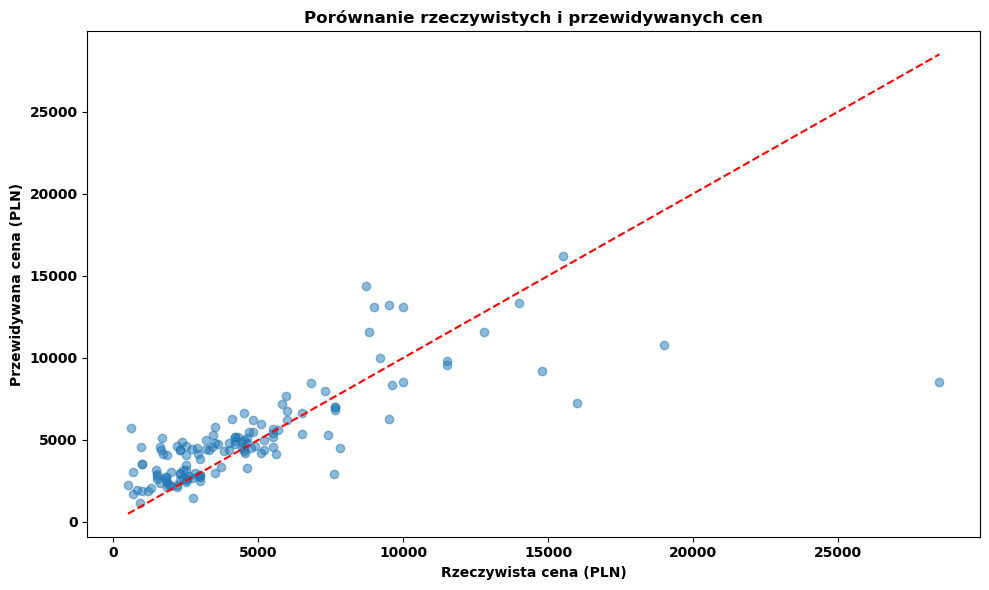

In [6]:
import json
import pandas as pd
import numpy as np
import re
import datetime
import logging
from typing import Dict, List, Optional, Tuple, Union

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


# Konfiguracja logowania
logging.basicConfig(
    level=logging.INFO, 
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)


class BikeValueEstimator:
    """
    Klasa do estymacji wartości rowerów na podstawie danych z ogłoszeń.
    
    Umożliwia:
    - Wczytywanie i przetwarzanie danych z plików JSON/CSV
    - Inżynierię cech dla modelu ML
    - Trening i ewaluację modelu na zbiorach treningowym i testowym
    - Predykcję cen rowerów
    - Klasyfikację ofert jako zaniżone/zawyżone/średnie
    - Wizualizację wyników i ważności cech
    """
    
    def __init__(self, 
                 price_threshold: float = 0.2, 
                 min_price: int = 500,
                 test_size: float = 0.2,
                 random_state: int = 42) -> None:
        """
        Inicjalizacja estymatora wartości rowerów.
        
        Args:
            price_threshold: Próg klasyfikacji cen (domyślnie 0.2 = +/- 20%)
            min_price: Minimalna cena filtrowanych ogłoszeń (domyślnie 500 PLN)
            test_size: Proporcja zbioru testowego (domyślnie 0.2 = 20%)
            random_state: Ziarno losowości (dla reprodukowalności wyników)
        """
        self.model_pipeline = None
        self.df_original = None
        self.df_processed = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.metrics = {}
        self.feature_importance = None
        
        # Parametry konfiguracyjne
        self.PRICE_CLASSIFICATION_THRESHOLD = price_threshold
        self.MIN_PRICE_FOR_BIKE = min_price
        self.CURRENT_YEAR = datetime.datetime.now().year
        self.TEST_SIZE = test_size
        self.RANDOM_STATE = random_state
        
    def load_data(self, file_path: str) -> Optional[pd.DataFrame]:
        """
        Wczytuje dane z pliku JSON lub CSV.
        
        Args:
            file_path: Ścieżka do pliku JSON lub CSV
            
        Returns:
            DataFrame z danymi lub None w przypadku błędu
        """
        try:
            if file_path.endswith('.json'):
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                df = pd.DataFrame(data)
            elif file_path.endswith('.csv'):
                df = pd.read_csv(file_path, encoding='utf-8')
            else:
                raise ValueError("Niewspierany format pliku. Podaj plik JSON lub CSV.")
            
            self.df_original = df.copy()
            return df
        except Exception as e:
            logger.error(f"Błąd wczytywania danych: {e}")
            return None
    
    def extract_year_from_text(self, text) -> Optional[int]:
        """Ekstrahuje rok (np. 2020, 2021) z tekstu."""
        if not isinstance(text, str):
            return None
        match = re.search(r'\b(19[89]\d|20[0-2]\d)\b', text)
        if match:
            year = int(match.group(0))
            if year <= self.CURRENT_YEAR:
                return year
        match_date = re.search(r'\b(\d{1,2}[./-]\d{1,2}[./-](19[89]\d|20[0-2]\d))\b', text)
        if match_date:
            date_parts = re.split(r'[./-]', match_date.group(1))
            year_from_date = int(date_parts[-1])
            if year_from_date <= self.CURRENT_YEAR:
                return year_from_date
        return None
    
    def standardize_size(self, size_val, desc_val) -> str:
        """Standaryzuje rozmiar ramy do kategorii XS, S, M, L, XL, XXL, Nieznany."""
        size_str = str(size_val).upper() if pd.notna(size_val) else ''
        desc_str = str(desc_val).upper() if pd.notna(desc_val) else ''
        combined = size_str + " " + desc_str

        if not combined.strip():
            return 'Nieznany'

        if 'XS' in combined or 'EXTRA SMALL' in combined: return 'XS'
        if 'S' in combined or 'SMALL' in combined or '15-16' in combined or '48' in combined or '49' in combined or '50' in combined or '51' in combined: return 'S'
        if 'M' in combined or 'MEDIUM' in combined or '17-18' in combined or '52' in combined or '53' in combined or '54' in combined: return 'M'
        if 'L' in combined or 'LARGE' in combined or '19-20' in combined or '55' in combined or '56' in combined or '57' in combined: return 'L'
        if 'XL' in combined or 'EXTRA LARGE' in combined or '21-22' in combined or '58' in combined or '59' in combined or '60' in combined: return 'XL'
        if 'XXL' in combined or '23' in combined: return 'XXL'

        if re.search(r'\b(15|16)\b', combined): return 'S'
        if re.search(r'\b(17|18)\b', combined): return 'M'
        if re.search(r'\b(19|20)\b', combined): return 'L'
        if re.search(r'\b(21|22)\b', combined): return 'XL'
        if re.search(r'\b(23|24)\b', combined): return 'XXL'

        if re.search(r'\b(48|49|50|51)\b', combined): return 'S'
        if re.search(r'\b(52|53|54)\b', combined): return 'M'
        if re.search(r'\b(55|56|57)\b', combined): return 'L'
        if re.search(r'\b(58|59|60|61)\b', combined): return 'XL'

        return 'Nieznany'
    
    def find_material(self, text) -> str:
        """Identyfikuje materiał ramy na podstawie tekstu."""
        if not isinstance(text, str): return 'Nieznany'
        text_lower = text.lower()
        if 'carbon' in text_lower or 'karbon' in text_lower: return 'Carbon'
        if 'aluminium' in text_lower or 'alu' in text_lower: return 'Aluminium'
        if 'stal' in text_lower or 'steel' in text_lower or 'crmo' in text_lower or 'cro-mo' in text_lower: return 'Stal'
        if 'tytan' in text_lower or 'titanium' in text_lower: return 'Tytan'
        return 'Nieznany'
    
    def find_brake_type(self, text) -> str:
        """Identyfikuje typ hamulców na podstawie tekstu."""
        if not isinstance(text, str): return 'Nieznany'
        text_lower = text.lower()
        if 'tarczowe hydrauliczne' in text_lower or 'hydrauliczne' in text_lower: return 'Tarczowe hydrauliczne'
        if 'tarczowe mechaniczne' in text_lower or 'mechaniczne' in text_lower: return 'Tarczowe mechaniczne'
        if 'tarczowe' in text_lower: return 'Tarczowe (nieokreślone)'
        if 'szczękowe' in text_lower or 'v-brake' in text_lower or 'caliper' in text_lower: return 'Szczękowe'
        if 'rolkowe' in text_lower: return 'Rolkowe'
        if 'torpedo' in text_lower or 'w piaście' in text_lower: return 'W piaście (Torpedo)'
        return 'Nieznany'
    
    def preprocess_data(self, df: pd.DataFrame) -> Optional[pd.DataFrame]:
        """
        Czyści dane i wykonuje inżynierię cech.
        
        Args:
            df: DataFrame z danymi do przetworzenia
            
        Returns:
            Przetworzony DataFrame lub None w przypadku błędu
        """
        if df is None or df.empty:
            logger.error("Brak danych do przetworzenia.")
            return None
            
        if 'price' not in df.columns:
            logger.error("Brak kolumny 'price' w danych.")
            return None
            
        # Konwersja 'price' na numeryczny
        df['price'] = pd.to_numeric(df['price'], errors='coerce')
        
        # Usuń wiersze bez ceny
        df.dropna(subset=['price'], inplace=True)
        
        # Filtruj ogłoszenia z niską ceną
        initial_count = len(df)
        df = df[df['price'] >= self.MIN_PRICE_FOR_BIKE].copy()
        logger.info(f"Odfiltrowano {initial_count - len(df)} ogłoszeń z ceną < {self.MIN_PRICE_FOR_BIKE} PLN.")
        logger.info(f"Pozostało {len(df)} ogłoszeń do analizy.")
        
        # Sprawdź minimalną wielkość danych
        if len(df) < 5:
            logger.warning("Zbyt mało danych do analizy ML (mniej niż 5 rekordów).")
            return None
        elif len(df) < 20:
            logger.warning("Bardzo mała ilość danych (mniej niż 20 rekordów). Wyniki będą mało wiarygodne.")
        
        # Upewnij się, że wszystkie potrzebne kolumny istnieją
        required_cols = ['brand', 'size', 'year', 'description', 'condition', 'frame_material', 'brake_type', 'parameters', 'title']
        for col in required_cols:
            if col not in df.columns:
                df[col] = None
        
        # Marka
        df['brand_cleaned'] = df.apply(lambda row: row['brand'] if pd.notna(row['brand']) and row['brand'] != 'Inna'
                                else (row['parameters'].get('Marka') if isinstance(row['parameters'], dict) and row['parameters'].get('Marka') != 'Inna' else 'Nieznana'), axis=1)
        df['brand_cleaned'] = df['brand_cleaned'].astype(str).str.upper().fillna('Nieznana')
        
        # Rok
        df['year_cleaned'] = pd.to_numeric(df['year'], errors='coerce')
        df['year_extracted_desc'] = df['description'].apply(self.extract_year_from_text)
        df['year_cleaned'] = df['year_cleaned'].fillna(df['year_extracted_desc'])
        df['bike_age'] = df['year_cleaned'].apply(lambda y: self.CURRENT_YEAR - y if pd.notna(y) and y <= self.CURRENT_YEAR else np.nan)
        
        # Rozmiar
        df['size_standardized'] = df.apply(lambda row: self.standardize_size(row['size'], row.get('description', '')), axis=1)
        
        # Stan
        df['condition_cleaned'] = df.apply(lambda row: row['condition'] if pd.notna(row['condition'])
                                       else (row['parameters'].get('Stan') if isinstance(row['parameters'], dict) else 'Nieznany'), axis=1)
        df['condition_cleaned'] = df['condition_cleaned'].fillna('Nieznany')
        
        # Materiał ramy
        df['frame_material_cleaned'] = df.apply(lambda row: row['frame_material'] if pd.notna(row['frame_material'])
                                            else (row['parameters'].get('Materiał ramy') if isinstance(row['parameters'], dict) else None), axis=1)
        df['frame_material_desc'] = df['description'].apply(self.find_material)
        df['frame_material_cleaned'] = df['frame_material_cleaned'].fillna(df['frame_material_desc'])
        df['frame_material_cleaned'] = df['frame_material_cleaned'].fillna('Nieznany')
        
        # Hamulce
        df['brake_type_cleaned'] = df.apply(lambda row: row['brake_type'] if pd.notna(row['brake_type'])
                                            else (row['parameters'].get('Typ hamulca') if isinstance(row['parameters'], dict) else None), axis=1)
        df['brake_type_desc'] = df['description'].apply(self.find_brake_type)
        df['brake_type_cleaned'] = df['brake_type_cleaned'].fillna(df['brake_type_desc'])
        df['brake_type_cleaned'] = df['brake_type_cleaned'].fillna('Nieznany')
        
        # Tekst do analizy
        df['text_features'] = df['title'].fillna('') + " " + df['description'].fillna('')
        
        self.df_processed = df.copy()
        return df
    
    def split_data(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
        """
        Dzieli dane na zbiór treningowy i testowy.
        
        Args:
            df: DataFrame z przetworzonymi danymi
            
        Returns:
            Tuple zawierający (X_train, X_test, y_train, y_test)
        """
        X = df.drop('price', axis=1)
        y = df['price']
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=self.TEST_SIZE, random_state=self.RANDOM_STATE
        )
        
        logger.info(f"Dane podzielone na zbiór treningowy ({len(X_train)} rekordów) i testowy ({len(X_test)} rekordów).")
        
        # Zapisz podzielone dane
        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
        
        return X_train, X_test, y_train, y_test
    
    def build_model(self) -> Optional[Pipeline]:
        """
        Buduje pipeline modelu ML do predykcji cen rowerów.
        
        Returns:
            Pipeline lub None w przypadku błędu
        """
        if self.df_processed is None:
            logger.error("Brak przetworzonych danych. Najpierw wywołaj preprocess_data().")
            return None
            
        df = self.df_processed
            
        # Wybierz cechy
        numeric_features = ['bike_age']
        if 'bike_age' not in df.columns or df['bike_age'].isnull().all():
            numeric_features = []
            
        categorical_features = ['brand_cleaned', 'size_standardized', 'condition_cleaned', 'frame_material_cleaned', 'brake_type_cleaned']
        categorical_features = [col for col in categorical_features if col in df.columns]
        
        text_feature = 'text_features'
        if text_feature not in df.columns:
            text_feature = None
            
        # Sprawdź, czy mamy jakiekolwiek cechy
        if not numeric_features and not categorical_features and not text_feature:
            logger.error("Brak cech do trenowania modelu.")
            return None
            
        # Przygotuj transformery
        transformers_list = []
        
        if numeric_features:
            numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ])
            transformers_list.append(('num', numeric_transformer, numeric_features))
            
        if categorical_features:
            categorical_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value='Nieznany')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ])
            transformers_list.append(('cat', categorical_transformer, categorical_features))
            
        if text_feature:
            text_transformer = Pipeline(steps=[
                ('tfidf', TfidfVectorizer(stop_words=['i', 'w', 'na', 'z', 'do', 'o', 'po', 'za', 'jest', 'oraz'], max_features=100, ngram_range=(1,2)))
            ])
            transformers_list.append(('text', text_transformer, text_feature))
            
        # Preprocessor
        preprocessor = ColumnTransformer(
            transformers=transformers_list,
            remainder='drop'
        )
        
        # Model pipeline
        self.model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(
                n_estimators=100,
                random_state=self.RANDOM_STATE,
                n_jobs=-1,
                max_depth=10,
                min_samples_leaf=2,
                max_features=0.8
            ))
        ])
        
        return self.model_pipeline
    
    def train_model(self) -> bool:
        """
        Trenuje model na podstawie podzielonych danych treningowych.
        
        Returns:
            bool: True jeśli trening zakończył się sukcesem, False w przeciwnym wypadku
        """
        if self.X_train is None or self.y_train is None:
            logger.error("Brak danych treningowych. Najpierw wywołaj split_data().")
            return False
            
        # Zbuduj model jeśli nie istnieje
        if self.model_pipeline is None:
            self.build_model()
            
        if self.model_pipeline is None:
            logger.error("Nie udało się zbudować modelu.")
            return False
            
        # Trenuj model
        try:
            self.model_pipeline.fit(self.X_train, self.y_train)
            logger.info("Model wytrenowany pomyślnie.")
            return True
        except Exception as e:
            logger.error(f"Błąd podczas treningu modelu: {e}")
            return False
    
    def evaluate_model(self) -> Dict[str, float]:
        """
        Ocenia model na zbiorze testowym używając różnych metryk.
        
        Returns:
            Słownik z metrykami oceny modelu
        """
        if self.model_pipeline is None or self.X_test is None or self.y_test is None:
            logger.error("Model nie został wytrenowany lub brak danych testowych.")
            return {}
            
        try:
            # Predykcja na zbiorze testowym
            y_pred = self.model_pipeline.predict(self.X_test)
            
            # Obliczenie metryk
            mae = mean_absolute_error(self.y_test, y_pred)
            mse = mean_squared_error(self.y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(self.y_test, y_pred)
            
            # Średni błąd procentowy (MAPE)
            mape = np.mean(np.abs((self.y_test - y_pred) / self.y_test)) * 100
            
            # Zapisz metryki
            self.metrics = {
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse,
                'R2': r2,
                'MAPE': mape
            }
            
            logger.info(f"Metryki modelu: MAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.4f}, MAPE={mape:.2f}%")
            return self.metrics
            
        except Exception as e:
            logger.error(f"Błąd podczas oceny modelu: {e}")
            return {}
    
    def predict_prices(self, df: pd.DataFrame) -> Optional[np.ndarray]:
        """
        Wykonuje predykcję cen dla podanego DataFrame.
        
        Args:
            df: DataFrame z cechami do predykcji
            
        Returns:
            Tablica z przewidywanymi cenami lub None w przypadku błędu
        """
        if self.model_pipeline is None:
            logger.error("Model nie został wytrenowany.")
            return None
            
        try:
            X = df.drop('price', axis=1) if 'price' in df.columns else df
            predictions = self.model_pipeline.predict(X)
            return predictions.round(2)
        except Exception as e:
            logger.error(f"Błąd podczas predykcji: {e}")
            return None
    
    def classify_price(self, actual: float, predicted: float) -> str:
        """
        Klasyfikuje cenę jako zawyżoną, zaniżoną lub średnią.
        
        Args:
            actual: Rzeczywista cena
            predicted: Przewidywana cena
            
        Returns:
            Klasyfikacja ceny jako string
        """
        if pd.isna(predicted) or predicted <= 0:
            return "Błąd predykcji"
            
        lower_bound = predicted * (1 - self.PRICE_CLASSIFICATION_THRESHOLD)
        upper_bound = predicted * (1 + self.PRICE_CLASSIFICATION_THRESHOLD)
        
        if actual < lower_bound:
            return "Zaniżona"
        elif actual > upper_bound:
            return "Zawyżona"
        else:
            return "Średnia"
    
    def extract_feature_importance(self) -> pd.DataFrame:
        """
        Ekstrahuje i formatuje ważność cech z modelu.
        
        Returns:
            DataFrame z nazwami cech i ich ważnością
        """
        if self.model_pipeline is None:
            logger.error("Model nie został wytrenowany.")
            return pd.DataFrame()
            
        try:
            # Pobierz regressor z pipeline
            regressor = self.model_pipeline.named_steps['regressor']
            # Pobierz preprocessor
            preprocessor = self.model_pipeline.named_steps['preprocessor']
            
            # Pobierz nazwy cech po preprocessingu
            feature_names = []
            for name, transformer, cols in preprocessor.transformers_:
                if hasattr(transformer, 'get_feature_names_out'):
                    # Dla transformerów które generują nowe nazwy (np. OneHotEncoder)
                    try:
                        transformed_names = transformer.get_feature_names_out(cols)
                        feature_names.extend(transformed_names)
                    except:
                        for col in cols:
                            feature_names.append(f"{name}_{col}")
                else:
                    # Dla prostych transformerów zachowaj oryginalne nazwy kolumn
                    for col in cols:
                        feature_names.append(col)
            
            # Pobierz ważność cech
            importances = regressor.feature_importances_
            
            # Utwórz DataFrame
            if len(feature_names) == len(importances):
                fi_df = pd.DataFrame({
                    'feature': feature_names,
                    'importance': importances
                }).sort_values('importance', ascending=False)
                
                self.feature_importance = fi_df
                return fi_df
            else:
                logger.warning(f"Niezgodność liczby nazw cech ({len(feature_names)}) i wartości ważności ({len(importances)}).")
                return pd.DataFrame({'feature': range(len(importances)), 'importance': importances})
                
        except Exception as e:
            logger.error(f"Błąd podczas ekstrakcji ważności cech: {e}")
            return pd.DataFrame()
    
    def plot_feature_importance(self, top_n: int = 10) -> None:
        """
        Tworzy wykres ważności cech.
        
        Args:
            top_n: Liczba najważniejszych cech do wyświetlenia
        """
        if self.feature_importance is None:
            self.extract_feature_importance()
            
        if self.feature_importance is None or self.feature_importance.empty:
            logger.error("Brak danych o ważności cech.")
            return
            
        try:
            # Wybierz top N cech
            top_features = self.feature_importance.head(top_n)
            
            plt.figure(figsize=(10, 6))
            sns.barplot(x='importance', y='feature', data=top_features)
            plt.title(f'Top {top_n} najważniejszych cech w modelu')
            plt.xlabel('Ważność cechy')
            plt.ylabel('Cecha')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            logger.error(f"Błąd podczas tworzenia wykresu: {e}")
    
    def plot_actual_vs_predicted(self) -> None:
        """Tworzy wykres porównujący rzeczywiste ceny z przewidywanymi."""
        if self.model_pipeline is None or self.X_test is None or self.y_test is None:
            logger.error("Model nie został wytrenowany lub brak danych testowych.")
            return
            
        try:
            # Predykcja na zbiorze testowym
            y_pred = self.model_pipeline.predict(self.X_test)
            
            # Utwórz wykres
            plt.figure(figsize=(10, 6))
            plt.scatter(self.y_test, y_pred, alpha=0.5)
            
            # Dodaj linię idealnej predykcji
            max_price = max(max(self.y_test), max(y_pred))
            min_price = min(min(self.y_test), min(y_pred))
            plt.plot([min_price, max_price], [min_price, max_price], 'r--')
            
            plt.title('Porównanie rzeczywistych i przewidywanych cen')
            plt.xlabel('Rzeczywista cena (PLN)')
            plt.ylabel('Przewidywana cena (PLN)')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            logger.error(f"Błąd podczas tworzenia wykresu: {e}")
    
    def save_model(self, file_path: str) -> bool:
        """
        Zapisuje wytrenowany model do pliku.
        
        Args:
            file_path: Ścieżka do pliku, gdzie zapisać model
            
        Returns:
            True jeśli zapisano pomyślnie, False w przeciwnym wypadku
        """
        if self.model_pipeline is None:
            logger.error("Brak wytrenowanego modelu do zapisania.")
            return False
            
        try:
            joblib.dump(self.model_pipeline, file_path)
            logger.info(f"Model zapisany do pliku: {file_path}")
            return True
        except Exception as e:
            logger.error(f"Błąd podczas zapisywania modelu: {e}")
            return False
    
    def load_model(self, file_path: str) -> bool:
        """
        Wczytuje model z pliku.
        
        Args:
            file_path: Ścieżka do pliku z modelem
            
        Returns:
            True jeśli wczytano pomyślnie, False w przeciwnym wypadku
        """
        try:
            self.model_pipeline = joblib.load(file_path)
            logger.info(f"Model wczytany z pliku: {file_path}")
            return True
        except Exception as e:
            logger.error(f"Błąd podczas wczytywania modelu: {e}")
            return False
    
    def run_cross_validation(self, n_folds: int = 5) -> Dict[str, float]:
        """
        Przeprowadza walidację krzyżową modelu.
        
        Args:
            n_folds: Liczba podziałów w walidacji krzyżowej
            
        Returns:
            Słownik z wynikami walidacji krzyżowej
        """
        if self.model_pipeline is None or self.df_processed is None:
            logger.error("Model nie został zbudowany lub brak przetworzonych danych.")
            return {}
            
        try:
            X = self.df_processed.drop('price', axis=1)
            y = self.df_processed['price']
            
            # Przeprowadź walidację krzyżową
            cv_scores = cross_val_score(
                self.model_pipeline, 
                X, y, 
                cv=n_folds, 
                scoring='neg_mean_squared_error',
                n_jobs=-1
            )
            
            # Konwertuj wyniki na RMSE
            rmse_scores = np.sqrt(-cv_scores)
            
            cv_results = {
                'mean_rmse': rmse_scores.mean(),
                'std_rmse': rmse_scores.std(),
                'all_scores': rmse_scores
            }
            
            logger.info(f"Walidacja krzyżowa ({n_folds} folds): Średni RMSE = {cv_results['mean_rmse']:.2f} ± {cv_results['std_rmse']:.2f}")
            return cv_results
            
        except Exception as e:
            logger.error(f"Błąd podczas walidacji krzyżowej: {e}")
            return {}
    
    def analyze_bikes(self, file_path: str = None, df: pd.DataFrame = None) -> Optional[pd.DataFrame]:
        """
        Przeprowadza kompletną analizę danych rowerowych.
        
        Args:
            file_path: Opcjonalna ścieżka do pliku z danymi
            df: Opcjonalny DataFrame z danymi
            
        Returns:
            DataFrame z wynikami lub None w przypadku błędu
        """
        # 1. Wczytaj dane
        if df is None:
            if file_path is None:
                logger.error("Nie podano danych ani ścieżki do pliku.")
                return None
            logger.info(f"Wczytywanie danych z: {file_path}")
            df = self.load_data(file_path)
            
        if df is None or df.empty:
            logger.error("Brak danych do analizy.")
            return None
        
        # 2. Przetwarzanie danych
        logger.info("Przetwarzanie danych...")
        processed_df = self.preprocess_data(df)
        if processed_df is None:
            return None
            
        # 3. Podział danych
        logger.info("Podział danych na zbiór treningowy i testowy...")
        self.split_data(processed_df)
        
        # 4. Budowa i trening modelu
        logger.info("Budowa i trening modelu...")
        model_built = self.build_model()
        if model_built is None:
            return None
            
        training_success = self.train_model()
        if not training_success:
            return None
            
        # 5. Ewaluacja modelu
        logger.info("Ewaluacja modelu...")
        metrics = self.evaluate_model()
        if not metrics:
            logger.warning("Nie można ocenić modelu, ale kontynuujemy predykcję.")
        
        # 6. Ekstrakcja ważności cech
        self.extract_feature_importance()
        
        # 7. Predykcja i klasyfikacja cen
        logger.info("Predykcja i klasyfikacja cen...")
        predicted_prices = self.predict_prices(processed_df)
        if predicted_prices is None:
            return None
            
        processed_df['predicted_price'] = predicted_prices
        
        processed_df['price_classification'] = processed_df.apply(
            lambda row: self.classify_price(row['price'], row['predicted_price']), 
            axis=1
        )
        
        logger.info("Analiza zakończona pomyślnie.")
        
        return processed_df
    
    def get_results_dataframe(self) -> Optional[pd.DataFrame]:
        """
        Zwraca DataFrame z wynikami analizy w czytelnym formacie.
        
        Returns:
            DataFrame z wynikami lub None w przypadku braku danych
        """
        if self.df_processed is None or 'predicted_price' not in self.df_processed.columns:
            logger.error("Brak przetworzonych danych z predykcją.")
            return None
            
        result_cols_mapping = {
            'title': 'Tytuł',
            'price': 'Cena Rzeczywista',
            'predicted_price': 'Cena Przewidywana (Model)',
            'price_classification': 'Klasyfikacja Ceny',
            'brand_cleaned': 'Marka',
            'year_cleaned': 'Rok',
            'size_standardized': 'Rozmiar',
            'condition_cleaned': 'Stan',
            'url': 'Link'
        }
        
        display_result_cols = [col for col in result_cols_mapping.keys() if col in self.df_processed.columns]
        
        if not display_result_cols:
            logger.error("Brak kolumn do wyświetlenia wyników.")
            return None
            
        results_df = self.df_processed[display_result_cols].copy()
        results_df.rename(columns=result_cols_mapping, inplace=True)
        
        return results_df
    
    def get_metrics_summary(self) -> str:
        """
        Zwraca podsumowanie metryk modelu jako sformatowany tekst.
        
        Returns:
            Tekst z podsumowaniem metryk
        """
        if not self.metrics:
            return "Brak dostępnych metryk. Najpierw wywołaj evaluate_model()."
            
        summary = "=== METRYKI MODELU ===\n"
        summary += f"MAE (Średni błąd bezwzględny): {self.metrics['MAE']:.2f} PLN\n"
        summary += f"RMSE (Pierwiastek średniego błędu kwadratowego): {self.metrics['RMSE']:.2f} PLN\n"
        summary += f"R² (Współczynnik determinacji): {self.metrics['R2']:.4f}\n"
        summary += f"MAPE (Średni procentowy błąd bezwzględny): {self.metrics['MAPE']:.2f}%\n"
        
        if self.X_train is not None and self.X_test is not None:
            summary += f"\nRozmiar zbioru treningowego: {len(self.X_train)} rekordów\n"
            summary += f"Rozmiar zbioru testowego: {len(self.X_test)} rekordów\n"
        
        return summary


# Przykładowe użycie
if __name__ == "__main__":
    # Inicjalizacja estymatora
    estimator = BikeValueEstimator(test_size=0.3, random_state=42)
    
    # Pełna analiza
    file_path = "./data/gravel_bikes.json"
    results_df = estimator.analyze_bikes(file_path=file_path)
    
    if results_df is not None:
        # Pokaż metryki
        print(estimator.get_metrics_summary())
        
        # Pokaż wyniki dla kilku przykładowych rowerów
        results = estimator.get_results_dataframe()
        if results is not None:
            print("\nPrzykładowe wyniki:")
            print(results.head().to_string())
        
        # Opcjonalnie: wizualizacje
        estimator.plot_feature_importance(top_n=10)
        estimator.plot_actual_vs_predicted()
        
        # Opcjonalnie: zapisz model
        # estimator.save_model("bike_price_model.joblib")

2025-04-04 10:15:54,735 - INFO - Odfiltrowano 90 ogłoszeń z ceną < 1000 PLN.
2025-04-04 10:15:54,735 - INFO - Pozostało 428 ogłoszeń do analizy.
2025-04-04 10:15:54,787 - INFO - Dane podzielone na zbiór treningowy (299 rekordów) i testowy (129 rekordów).
2025-04-04 10:15:55,013 - INFO - Model wytrenowany pomyślnie.
2025-04-04 10:15:55,060 - INFO - Metryki modelu: MAE=1151.90, RMSE=1532.94, R2=0.7033, MAPE=33.04%
2025-04-04 10:15:55,089 - WARNING - Niezgodność liczby nazw cech (177) i wartości ważności (152).
2025-04-04 10:15:55,210 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-04 10:15:55,215 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



=== METRYKI MODELU ===
MAE: 1151.90 PLN
MSE: 2349917.86 PLN
RMSE: 1532.94 PLN
R2: 0.7033
MAPE: 33.04%

=== NAJWAŻNIEJSZE CECHY ===
 feature  importance
       0    0.008411
       1    0.000000
       2    0.000000
       3    0.000000
       4    0.000140
       5    0.004043
       6    0.000023
       7    0.000000
       8    0.000000
       9    0.000025

=== ROZKŁAD KLASYFIKACJI CEN ===
Średnia: 254 (59.3%)
Zaniżona: 117 (27.3%)
Zawyżona: 57 (13.3%)

=== TWORZENIE WIZUALIZACJI ===
Zapisano wykres ważności cech: bike_feature_importance.png
Zapisano wykres predykcji: bike_price_predictions.png
Zapisano wykres błędów procentowych: bike_price_percent_errors.png


2025-04-04 10:15:57,849 - INFO - Walidacja krzyżowa (5 folds): Średni RMSE = 2278.32 ± 405.91
2025-04-04 10:15:57,978 - INFO - Model zapisany do pliku: bike_price_model.joblib
2025-04-04 10:15:57,979 - ERROR - Brak przetworzonych danych z predykcją.



=== WALIDACJA KRZYŻOWA (5-FOLD) ===
Średni RMSE: 2278.32 ± 405.91 PLN


AttributeError: 'NoneType' object has no attribute 'to_csv'

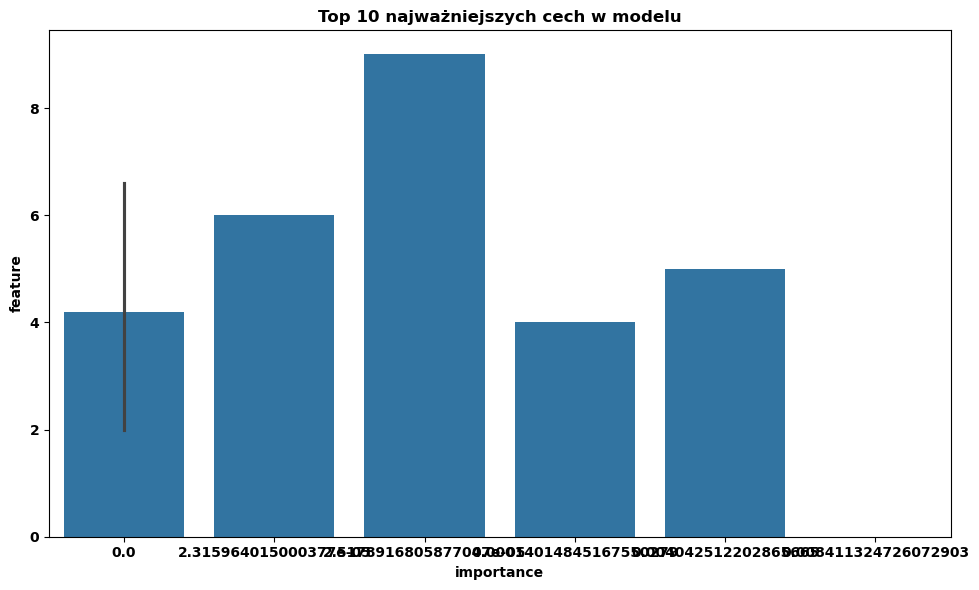

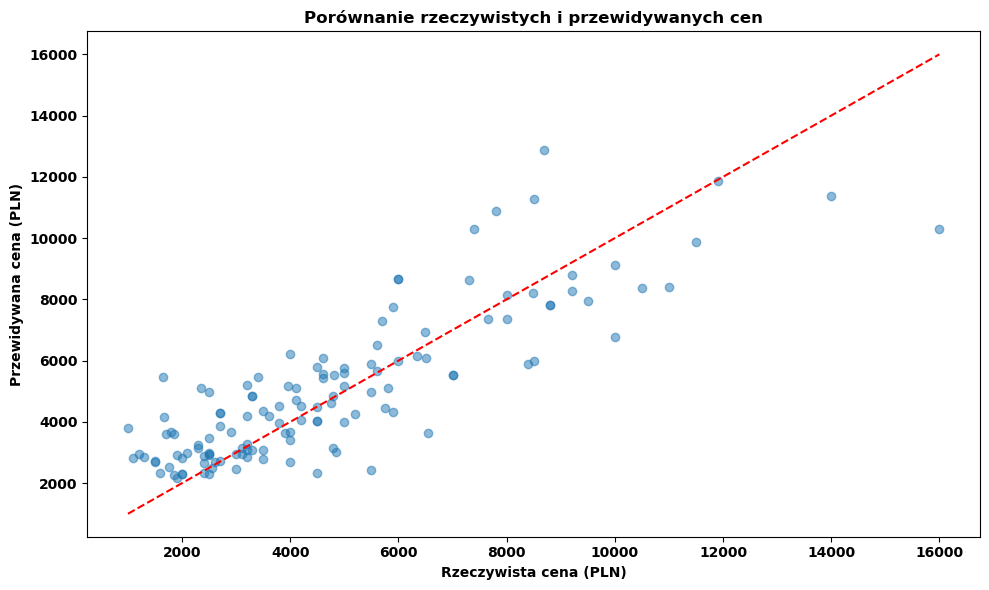

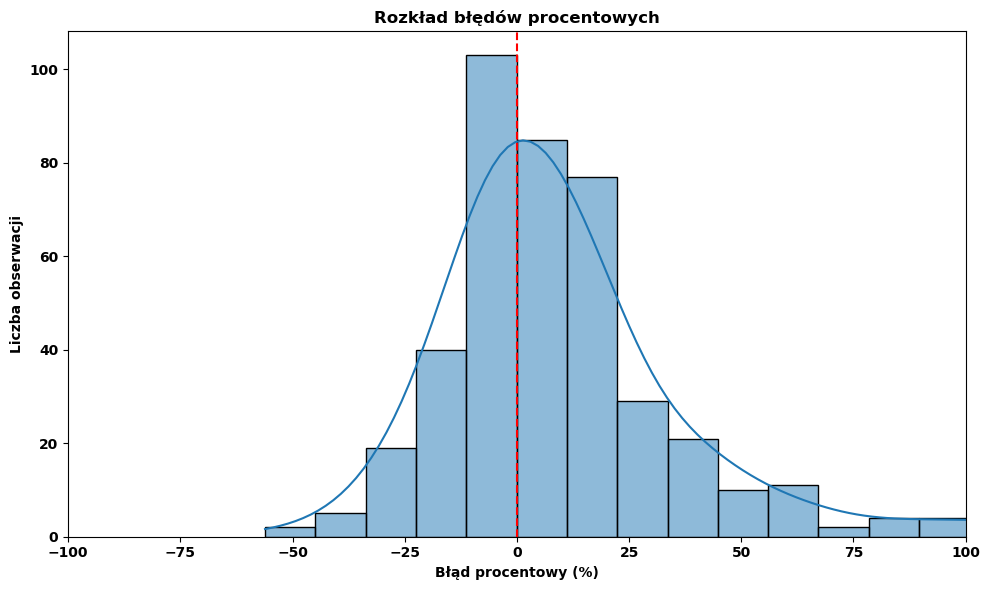

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ścieżka do pliku z danymi
FILE_PATH = "./data/gravel_bikes.json"

def main():
    """
    Główna funkcja demonstrująca użycie BikeValueEstimator
    z podziałem na zbiór treningowy i testowy, oraz analizą metryk.
    """
    # Inicjalizacja estymatora z niestandardowymi parametrami
    estimator = BikeValueEstimator(
        price_threshold=0.15,  # 15% próg klasyfikacji cen
        min_price=1000,        # Minimalna cena 1000 PLN
        test_size=0.3,         # 30% danych jako zbiór testowy
        random_state=42        # Ziarno losowości dla reprodukowalności
    )
    
    # 1. Wczytaj dane
    df = estimator.load_data(FILE_PATH)
    if df is None:
        print("Nie udało się wczytać danych. Sprawdź ścieżkę do pliku.")
        return
    
    # 2. Przetwarzanie danych
    processed_df = estimator.preprocess_data(df)
    if processed_df is None:
        print("Nie udało się przetworzyć danych.")
        return
    
    # 3. Podział na zbiór treningowy i testowy
    X_train, X_test, y_train, y_test = estimator.split_data(processed_df)
    
    # 4. Budowa modelu
    estimator.build_model()
    
    # 5. Trening modelu
    if not estimator.train_model():
        print("Nie udało się wytrenować modelu.")
        return
    
    # 6. Ewaluacja modelu
    metrics = estimator.evaluate_model()
    print("\n=== METRYKI MODELU ===")
    for metric_name, value in metrics.items():
        if metric_name == 'MAPE':
            print(f"{metric_name}: {value:.2f}%")
        elif metric_name == 'R2':
            print(f"{metric_name}: {value:.4f}")
        else:
            print(f"{metric_name}: {value:.2f} PLN")
    
    # 7. Analiza ważności cech
    feature_importance = estimator.extract_feature_importance()
    print("\n=== NAJWAŻNIEJSZE CECHY ===")
    print(feature_importance.head(10).to_string(index=False))
    
    # 8. Predykcja i klasyfikacja na całym zbiorze
    processed_df['predicted_price'] = estimator.predict_prices(processed_df)
    processed_df['price_classification'] = processed_df.apply(
        lambda row: estimator.classify_price(row['price'], row['predicted_price']), 
        axis=1
    )
    
    # 9. Podsumowanie klasyfikacji cen
    price_classification = processed_df['price_classification'].value_counts()
    print("\n=== ROZKŁAD KLASYFIKACJI CEN ===")
    for category, count in price_classification.items():
        percent = count / len(processed_df) * 100
        print(f"{category}: {count} ({percent:.1f}%)")
    
    # 10. Wizualizacje
    print("\n=== TWORZENIE WIZUALIZACJI ===")
    
    # Wykres ważności cech
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
    plt.title('Top 10 najważniejszych cech w modelu')
    plt.tight_layout()
    plt.savefig('bike_feature_importance.png')
    print("Zapisano wykres ważności cech: bike_feature_importance.png")
    
    # Wykres rzeczywiste vs przewidywane ceny
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, estimator.model_pipeline.predict(X_test), alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title('Porównanie rzeczywistych i przewidywanych cen')
    plt.xlabel('Rzeczywista cena (PLN)')
    plt.ylabel('Przewidywana cena (PLN)')
    plt.tight_layout()
    plt.savefig('bike_price_predictions.png')
    print("Zapisano wykres predykcji: bike_price_predictions.png")
    
    # Histogram błędów procentowych
    plt.figure(figsize=(10, 6))
    percent_errors = ((processed_df['predicted_price'] - processed_df['price']) / processed_df['price']) * 100
    sns.histplot(percent_errors, bins=30, kde=True)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title('Rozkład błędów procentowych')
    plt.xlabel('Błąd procentowy (%)')
    plt.ylabel('Liczba obserwacji')
    plt.xlim(-100, 100)
    plt.tight_layout()
    plt.savefig('bike_price_percent_errors.png')
    print("Zapisano wykres błędów procentowych: bike_price_percent_errors.png")
    
    # 11. Walidacja krzyżowa
    cv_results = estimator.run_cross_validation(n_folds=5)
    if cv_results:
        print(f"\n=== WALIDACJA KRZYŻOWA (5-FOLD) ===")
        print(f"Średni RMSE: {cv_results['mean_rmse']:.2f} ± {cv_results['std_rmse']:.2f} PLN")
    
    # 12. Zapisz model i wyniki
    estimator.save_model("bike_price_model.joblib")
    
    results_df = estimator.get_results_dataframe()
    results_df.to_csv("bike_price_results.csv", index=False)
    print("\nZapisano model: bike_price_model.joblib")
    print("Zapisano wyniki: bike_price_results.csv")
    
    print("\nAnaliza zakończona pomyślnie.")

if __name__ == "__main__":
    main()

In [5]:
import pandas as pd

# Sposób 1: Analiza z pliku
def analyze_from_file():
    print("=== Analiza z pliku ===")
    # Inicjalizacja estymatora
    estimator = BikeValueEstimator()
    
    # Pełna analiza z podaniem ścieżki do pliku
    file_path = "./data/gravel_bikes.json"
    results = estimator.analyze_prices(file_path=file_path)
    
    if results is not None:
        # Pobranie ramki danych z wynikami w czytelnym formacie
        results_df = estimator.get_results_dataframe(results)
        
        # Wyświetlenie wyników
        print("\nWyniki analizy:")
        print("-" * 50)
        print(results_df.to_string(index=False))
        
        # Można też zapisać wyniki do pliku CSV
        results_df.to_csv("wyniki_analizy.csv", index=False)
        print("Wyniki zapisano w pliku: wyniki_analizy.csv")
    
    return results

# Sposób 2: Etapy analizy osobno
def analyze_step_by_step():
    print("\n=== Analiza krok po kroku ===")
    # Inicjalizacja estymatora
    estimator = BikeValueEstimator()
    
    # 1. Wczytanie danych
    file_path = "./data/gravel_bikes.json"
    df = estimator.load_data(file_path)
    
    if df is None or df.empty:
        print("Nie udało się wczytać danych.")
        return None
    
    # 2. Przetwarzanie danych
    processed_df = estimator.preprocess_data(df)
    
    if processed_df is None:
        print("Nie udało się przetworzyć danych.")
        return None
    
    # 3. Budowa i trening modelu
    estimator.build_model(processed_df)
    success = estimator.train_model(processed_df)
    
    if not success:
        print("Nie udało się wytrenować modelu.")
        return None
    
    # 4. Predykcja cen
    predicted_prices = estimator.predict_prices(processed_df)
    processed_df['predicted_price'] = predicted_prices
    
    # 5. Klasyfikacja cen
    processed_df['price_classification'] = processed_df.apply(
        lambda row: estimator.classify_price(row['price'], row['predicted_price']), 
        axis=1
    )
    
    # 6. Wyświetlenie wyników
    results_df = estimator.get_results_dataframe(processed_df)
    print("\nWyniki analizy krok po kroku:")
    print("-" * 50)
    print(results_df.head().to_string(index=False))
    
    return processed_df

# Sposób 3: Analiza istniejącego DataFrame
def analyze_existing_dataframe():
    print("\n=== Analiza istniejącego DataFrame ===")
    # Załóżmy, że mamy już wczytane dane
    df = pd.read_json("./data/gravel_bikes.json")
    
    # Inicjalizacja estymatora i analiza
    estimator = BikeValueEstimator()
    results = estimator.analyze_prices(df=df)
    
    if results is not None:
        print(f"Analizowano {len(results)} rowerów.")
        
        # Można też zbadać rozkład klasyfikacji cen
        price_class_counts = results['price_classification'].value_counts()
        print("\nRozkład klasyfikacji cen:")
        for category, count in price_class_counts.items():
            percent = count / len(results) * 100
            print(f"{category}: {count} ({percent:.1f}%)")
    
    return results

# Wykonanie analizy
if __name__ == "__main__":
    # Wybierz jedną z metod analizy
    results = analyze_from_file()
    # results = analyze_step_by_step()
    # results = analyze_existing_dataframe()

=== Analiza z pliku ===
Analiza cen rowerów używanych - Start
------------------------------
Wczytywanie danych z: ./data/gravel_bikes.json
Przetwarzanie danych i inżynieria cech...
Odfiltrowano 63 ogłoszeń z ceną < 500 PLN.
Pozostało 455 ogłoszeń do analizy.
Trening modelu regresyjnego...
Predykcja i klasyfikacja cen...
Analiza zakończona.

Wyniki analizy:
--------------------------------------------------
                                                                                                                Tytuł  Cena Rzeczywista  Cena Przewidywana (Model) Klasyfikacja Ceny       Marka    Rok Rozmiar    Stan                                                                                                                    Link
                                                                          Triban  RC 5 2 0 Wrocław Fabryczna • OLX.pl            2000.0                    2511.72          Zaniżona      TRIBAN    NaN       S Używane                                      